## Dataset 
Dataset DeepScores V2 struttura  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report
!apt-get install libmagic-dev
!pip install python-magic
import os
from os import remove
import random
from pathlib import Path
from PIL import Image
import pickle

import tensorflow as tf
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization
from matplotlib import pyplot as plt

try: 
  import augly.image as imaugs
except ModuleNotFoundError:
  !pip install augly
  import augly.image as imaugs



COLAB_ROOT = '/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/oemer' #'/content/drive/MyDrive/oemer-main/oemer'
PROJECT_ROOT ='/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main'  #'/content/drive/MyDrive/oemer-main/oemer'
DATASET_PATH = '/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation' #'/content/drive/MyDrive/oemer-main/dataset/ds2_dense/segmentation'

import sys 
sys.path.insert(0,COLAB_ROOT)
from bbox import get_bbox, merge_nearby_bbox, draw_bounding_boxes, rm_merge_overlap_bbox


TARGET_WIDTH = 40
TARGET_HEIGHT = 70
DISTANCE = 10




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagic-dev is already the newest version (1:5.32-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Funzioni per la creazione del dataset e l'individuazione di esempi**

In [6]:

FILES = os.listdir(DATASET_PATH)

def find_example(color: int,max_count=500,mark_value=200):
    global FILES
    random.shuffle(FILES)
    for ff in FILES :
        path = os.path.join(DATASET_PATH, ff)
        img = Image.open(path)
        arr = np.array(img)
        if color in arr:
          print(f'{path} collect')
          FILES.remove(ff)
          return np.where(arr==color, mark_value, arr)
        FILES.remove(ff)


def collect(color, out_path, samples=100,reset = True):
    global FILES
    if reset:
      FILES =  os.listdir(DATASET_PATH)
    out_path = Path(out_path)
    if not out_path.exists():
        out_path.mkdir()

    cur_samples = 0
    add_space = 10
    idx = 0
    while cur_samples < samples and len(FILES) > 0 :
      
        arr = find_example(color)
        if arr is None:
            continue
        arr[arr!=200] = 0
        boxes = get_bbox(arr)
        if len(boxes) > 1:
            boxes = merge_nearby_bbox(boxes, DISTANCE)
        boxes = rm_merge_overlap_bbox(boxes)
        for box in boxes:
            if idx >= samples:
                break
            print(f"{idx+1}/{samples}", end='\r')
            patch = arr[box[1]-add_space:box[3]+add_space, box[0]-add_space:box[2]+add_space]
            ratio = random.choice(np.arange(0.6, 1.3, 0.1))
            tar_w = int(ratio * patch.shape[1])
            tar_h = int(ratio * patch.shape[0])
            img = imaugs.resize(Image.fromarray(patch.astype(np.uint8)), width=tar_w, height=tar_h)

            seed = random.randint(0, 1000)
            img = imaugs.perspective_transform(img, seed=seed, sigma=3)
            img = np.where(np.array(img)>0, 255, 0)
            Image.fromarray(img.astype(np.uint8)).save(out_path / f"{idx}.png")
            idx += 1

        cur_samples += len(boxes)
    print()


In [3]:

def train_tensorflow_model(get_model,folders,k_fold = None,epochs = 10):
    class_map = {idx: Path(ff).name for idx, ff in enumerate(folders)}
    X = []
    y = []
    samples = None
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        idx = 0
        for ff in folder.iterdir():
            if samples is not None and idx >= samples:
                break
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            X.append(arr)
            y.append(cidx)
            idx += 1

    
    X = np.array(X)
    y = np.array(y)
    print(f'Train Size : {X.shape}')

    if k_fold == None:

      train_x = np.array(X)[..., np.newaxis]
      train_y = tf.one_hot(y, len(folders))



      output_types = (tf.uint8, tf.uint8)
      output_shapes = ((TARGET_HEIGHT, TARGET_WIDTH, 1), (len(folders)))
      print(train_x.shape)
    
      training_set = tf.data.Dataset.from_generator(lambda: zip(train_x, train_y), output_types=output_types, output_shapes=output_shapes)
      training_set = training_set.shuffle(len(train_y), reshuffle_each_iteration=True)
      training_set = training_set.repeat(5)
      training_set = training_set.batch(16)
    
     
      model = get_model(folders)

      history  = model.fit(training_set, batch_size = 64, epochs=epochs,verbose = 1)
      """
      plt.title('Loss scores')
      plt.xlabel('Epoch')
      plt.ylabel('Loss Value')
      plt.plot(history.history['train_loss'])
      plt.plot(history.history['val_loss'])
      plt.show()

      plt.title('Accuracy scores')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy ')
      plt.plot(history.history['train_accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.show()
      """

    else : 


      from sklearn.model_selection import KFold
      kf = KFold(n_splits=k_fold)


      for train_index, val_index in kf.split(X,y):
        print(train_index, val_index)
        train_x, val_x = X[train_index], X[val_index]
        train_y, val_y = y[train_index], y[val_index]

        train_x = np.array(train_x)[..., np.newaxis]
        train_y = tf.one_hot(train_y, len(folders))

        val_x = np.array(val_x)[..., np.newaxis]
        val_y = tf.one_hot(val_y, len(folders))

        output_types = (tf.uint8, tf.uint8)
        output_shapes = ((TARGET_HEIGHT, TARGET_WIDTH, 1), (len(folders)))
        print(train_x.shape)
        print(val_x.shape)

      
        training_set = tf.data.Dataset.from_generator(lambda: zip(train_x, train_y), output_types=output_types, output_shapes=output_shapes)
        training_set = training_set.shuffle(len(train_y), reshuffle_each_iteration=True)
        training_set = training_set.repeat(5)
        training_set = training_set.batch(16)


        validation_set = tf.data.Dataset.from_generator(lambda: zip(val_x, val_y), output_types=output_types, output_shapes=output_shapes)
        validation_set = validation_set.shuffle(len(val_y), reshuffle_each_iteration=True)
        validation_set = validation_set.repeat(5)
        validation_set = validation_set.batch(16)
        

        #model = get_model(classes = len(folders),shape = (TARGET_HEIGHT, TARGET_WIDTH, 1))
      

      
        model = get_model(folders)

        history  = model.fit(training_set, validation_data = validation_set, batch_size=16, epochs=10,verbose = 1)
        plt.title('Loss scores')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.plot(history.history['train_loss'])
        plt.plot(history.history['val_loss'])
        plt.show()

        plt.title('Accuracy scores')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy ')
        plt.plot(history.history['train_accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.show()

    return model, class_map

In [4]:


def test_tensorflow_model(model, folders):
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np

    test_x = []
    test_y = []
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        files = list(folder.iterdir())
        random.shuffle(files)
        for ff in files:
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            test_x.append(arr)
            test_y.append(cidx)

    test_x = np.array(test_x)[..., np.newaxis]
    test_y = np.array(test_y)

    print(f'Test Size : {test_x.shape}')
    test_result = []
    batch_size = 16
    for idx in range(0, len(test_x), batch_size):
        data = test_x[idx:idx+batch_size]
        pred = model.predict(data)
        pidx = np.argmax(pred, axis=-1)
        test_result.extend(list(pidx))

    test_result = np.array(test_result)

    tp = test_result[test_result==test_y].size
    acc = tp / len(test_y)

    cm = confusion_matrix(test_y, test_result)
    import os 

    display_labels = [os.path.split(f)[1] for f in folders] 

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
    plt.show()

    print(classification_report(test_result, test_y, target_names=display_labels))





In [ ]:
display_labels=[os.path.normpath(f) for f in folders]
display_labels

['rest_whole',
 'rest_quarter',
 'rest_8th',
 'rest_8th',
 'rest_16th',
 'rest_32nd',
 'rest_64th',
 'sharp',
 'flat',
 'natural',
 'gclef',
 'fclef']

In [9]:
GENERATE_DATASET = True
TRAINING = True

TRAIN_DATAPATH = f"{COLAB_ROOT}/train_data"
TEST_DATAPATH = f"{COLAB_ROOT}/test_data"

samples = 200
def get_model(folders):
  model = tf.keras.models.Sequential([
          tf.keras.layers.InputLayer(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 1)),

          tf.keras.layers.Conv2D(64, (6, 6), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),


           tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(len(folders), activation='softmax')
      ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


"""
color_map = {
  74: "sharp",
  70: "flat",
  72: "natural"
}
"""
color_map = {
     10: 'gclef',
     13: 'fclef'
 }



"""
color_map = {
  97: 'rest_whole',
  98: 'rest_half',
  99: 'rest_quarter',
  100: 'rest_8th',
  101: 'rest_16th',
  102: 'rest_32nd',
  103: 'rest_64th',
  10: 'gclef',
  13: 'fclef',
  74: "sharp",
  70: "flat",
  72: "natural"
}
"""
if not os.path.exists(TRAIN_DATAPATH):
  print(f'create directory {TRAIN_DATAPATH}')
  os.mkdir(TRAIN_DATAPATH)

if not os.path.exists(TEST_DATAPATH):
  os.mkdir(TEST_DATAPATH)
  print(f'create directory {TRAIN_DATAPATH}')

if GENERATE_DATASET:
#genera un dataset di segmenti di immagini dividendoli in cartelle
  for color, name in color_map.items():
      print(f'collect {name} examples')
      collect(color, f"{TRAIN_DATAPATH}/{name}", samples=samples)
      collect(color, f"{TEST_DATAPATH}/{name}", samples=samples,reset = False)




collect gclef examples
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-169480697-aug-gutenberg1939--page-5_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-110143839-aug-lilyjazz-_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-209045200156685633-aug-emmentaler-_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-101766503886095953-aug-gonville--page-4_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-165143054-aug-gonville--page-11_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-263172443869766193-aug-beethoven--page-2_seg.png collect
/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation/lg-299237139601375755-aug-gonvil

Loading data
Train Size : (2200, 70, 40)
(2200, 70, 40, 1)
Epoch 1/6
688/688 [==============================] - 229s 331ms/step - loss: 0.4115 - accuracy: 0.8855
Epoch 2/6
688/688 [==============================] - 226s 327ms/step - loss: 0.1270 - accuracy: 0.9621
Epoch 3/6
688/688 [==============================] - 225s 325ms/step - loss: 0.1011 - accuracy: 0.9749
Epoch 4/6
688/688 [==============================] - 226s 327ms/step - loss: 0.0953 - accuracy: 0.9768
Epoch 5/6
688/688 [==============================] - 226s 327ms/step - loss: 0.0629 - accuracy: 0.9855
Epoch 6/6
688/688 [==============================] - 226s 327ms/step - loss: 0.0434 - accuracy: 0.9884
Loading data
Test Size : (2200, 70, 40, 1)
1/1 [==============================] - 0s 42ms/step


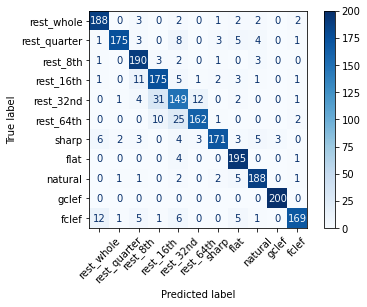

              precision    recall  f1-score   support

  rest_whole       0.94      0.90      0.92       209
rest_quarter       0.88      0.97      0.92       180
    rest_8th       0.95      0.86      0.90       220
   rest_16th       0.88      0.80      0.83       220
   rest_32nd       0.74      0.72      0.73       207
   rest_64th       0.81      0.91      0.86       178
       sharp       0.85      0.94      0.90       181
        flat       0.97      0.89      0.93       220
     natural       0.94      0.92      0.93       204
       gclef       1.00      0.99      0.99       203
       fclef       0.84      0.95      0.89       178

    accuracy                           0.89      2200
   macro avg       0.89      0.90      0.89      2200
weighted avg       0.89      0.89      0.89      2200



In [11]:

# folders = ["gclef", "fclef"]; model_name = "clef"
# folders = ["sharp", "flat", "natural"]; model_name = "sfn"
folders = ["rest_whole", "rest_quarter", "rest_8th", "rest_16th", "rest_32nd", "rest_64th","sharp", "flat", "natural","gclef", "fclef"]; model_name = "rests"
# folders = ["rest_8th", "rest_16th", "rest_32nd", "rest_64th"]; model_name = "rests_above8"
# folders = ['clefs', 'sfns']; model_name = 'clefs_sfns'


if TRAINING:
  model, class_map = train_tensorflow_model(get_model,[f"{TRAIN_DATAPATH}/{folder}" for folder in folders],epochs=6) # TF-based model

test_tensorflow_model(model, [f"{TEST_DATAPATH}/{folder}" for folder in folders])

output = {'model': model, 'w': TARGET_WIDTH, 'h': TARGET_HEIGHT, 'class_map': class_map}

if not os.path.exists(f"{COLAB_ROOT}/tf_models/"):
  os.mkdir(f"{COLAB_ROOT}/tf_models/")
  
pickle.dump(output, open(f"{COLAB_ROOT}/tf_models/{model_name}.model", "wb"))

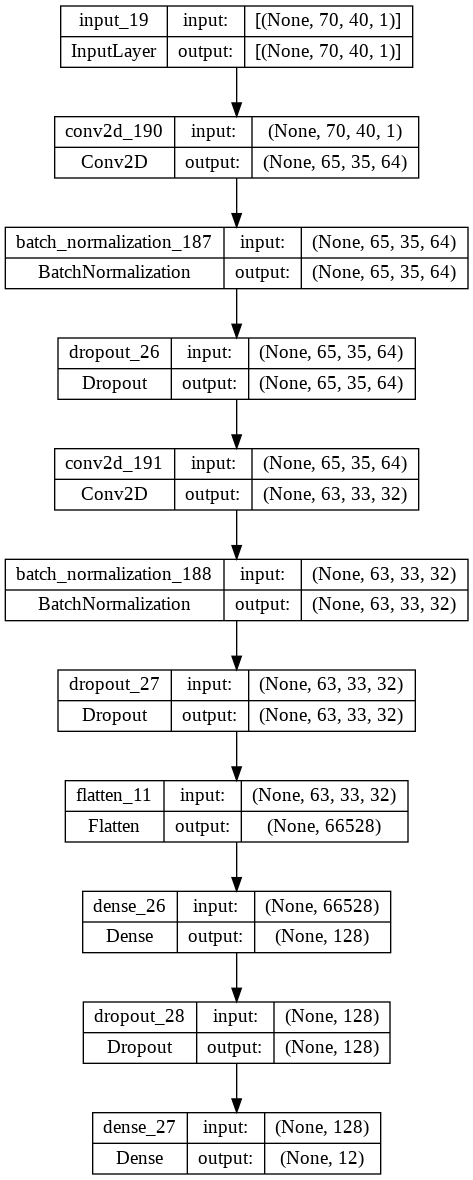

In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)